# Assignment III: _Dissecting Spotify Valence_<br>
In this assignment we will dissect Spotify's Valence metric. Spotify uses a metric called valence to measure the happiness of a track.<br> The metric itself, however, was not developed by Spotify. It was originally developed by Echo Nest, a company that was bought by Spotify in 2014.<br> We don't know exactly how valence is calculated. Some details are given by a blog post, which you can find here:

>https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013

Our task is to untangle the mystery behind valence and propose how this is derived.


---


![](https://www.pngrepo.com/png/148531/512/spotify-logo.png)


 


---
 >Panagiotis Giannopoulos, P3352102 <br />
 >MSc in Data Science <br />
 >Athens University of Economics and Business <br />
 pgiannopoulos@aueb.gr

## Part 1: Explore which Track Features Influence Valence
---
We will use inferential statistics methods to study how track features influence valence. We will use the Spotify API <br>to get access and analyse those features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

%matplotlib inline

### Data 
We will download a dataset of songs from Kaggle. Then through the Spotify API we will download the audio features of each song.

In [2]:
# https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db
data = pd.read_csv('data/SpotifyFeatures.csv')

### Spotify Credentials and API

In [3]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'], config['client_secret']) # Insert API Keys
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #Spotify Credential Client

# Spotify API download song features(100 each time)
features = {}
all_track_ids = list(data['track_id'].unique())
start = 0
num_tracks = 100

while start < len(all_track_ids):
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks
    
print('Total Songs ids:', len(data['track_id'].unique()))
print('Songs ids download from Spotify:', len(features))

Total Songs ids: 176774
Songs ids download from Spotify: 176774


### Tracks and Audio Features Dataset
Having download all the audio features we will keep the numeric values and drop the other ones. Also we will transform the song duration in minutes and select the ones that are below 10 minutes long.

In [4]:
# Tracks dataframe preparation
tracks = pd.DataFrame.from_dict(features, orient='index')
tracks = tracks.reset_index().rename(columns={'index':'song_id'}).drop(['type','id','uri','track_href','analysis_url'],axis=1)
# Convert song duration from ms to min
tracks['duration_min'] = tracks.duration_ms/60000 
# Drop songs below 1 min and above 10 min
tracks = tracks.loc[(tracks['duration_min']>=1) & (tracks['duration_min'] <=10)].drop(['duration_ms'],axis=1) 
tracks

,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_min
0,0BRjO6ga9RKCKjfDqeFgWV,0.389,0.910,1,-1.828,1,0.0525,0.6110,0.000000,0.3460,0.816,166.969,4,1.656217
1,0BjC1NfoEOOusryehmNudP,0.591,0.737,6,-5.559,0,0.0877,0.2460,0.000000,0.1510,0.815,174.003,4,2.289550
2,0CoSDzoNIKCRs124s9uTVy,0.663,0.131,0,-13.879,0,0.0362,0.9520,0.000000,0.1030,0.368,99.488,5,2.837783
3,0Gc6TVm52BwZD07Ki6tIvf,0.241,0.326,1,-12.178,1,0.0390,0.7030,0.000000,0.0985,0.226,171.782,4,2.540450
4,0IuslXpMROHdEPvSl1fTQK,0.331,0.225,5,-21.150,1,0.0456,0.9500,0.123000,0.2020,0.390,140.576,4,1.377083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176769,1U0OMWvR89Cm20vCNar50f,0.736,0.701,10,-4.345,0,0.1000,0.2310,0.000000,0.2030,0.770,99.991,4,3.711117
176770,2gGqKJWfWbToha2YmDxnnj,0.802,0.516,2,-9.014,1,0.2140,0.1040,0.000472,0.1050,0.482,175.663,4,3.352883
176771,2iZf3EUedz9MPqbAvXdpdA,0.423,0.337,10,-13.092,0,0.0436,0.5660,0.000000,0.2760,0.497,80.023,4,2.411117
176772,1qWZdkBl4UVPj9lK6HuuFM,0.785,0.683,4,-6.944,0,0.0337,0.0329,0.000880,0.2370,0.969,113.830,4,4.707450


### Statistics

In [5]:
# Statistics for tracks dataset
tracks.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,172320.0,0.543461,0.189324,0.00000,0.41900,0.560000,0.685000,0.989
energy,172320.0,0.561797,0.274008,0.00002,0.35500,0.598000,0.792000,0.999
key,172320.0,5.230026,3.549544,0.00000,2.00000,5.000000,8.000000,11.000
loudness,172320.0,-9.989422,6.308239,-52.45800,-12.58225,-8.079000,-5.588000,3.744
mode,172320.0,0.658339,0.474268,0.00000,0.00000,1.000000,1.000000,1.000
speechiness,172320.0,0.123688,0.198152,0.00000,0.03660,0.049200,0.099800,0.967
acousticness,172320.0,0.395405,0.363987,0.00000,0.04300,0.273000,0.777000,0.996
instrumentalness,172320.0,0.167305,0.319138,0.00000,0.00000,0.000065,0.075500,0.998
liveness,172320.0,0.222215,0.208324,0.00967,0.09730,0.129000,0.274000,1.000
valence,172320.0,0.453654,0.266882,0.00000,0.22600,0.443000,0.668000,1.000


### Plots 

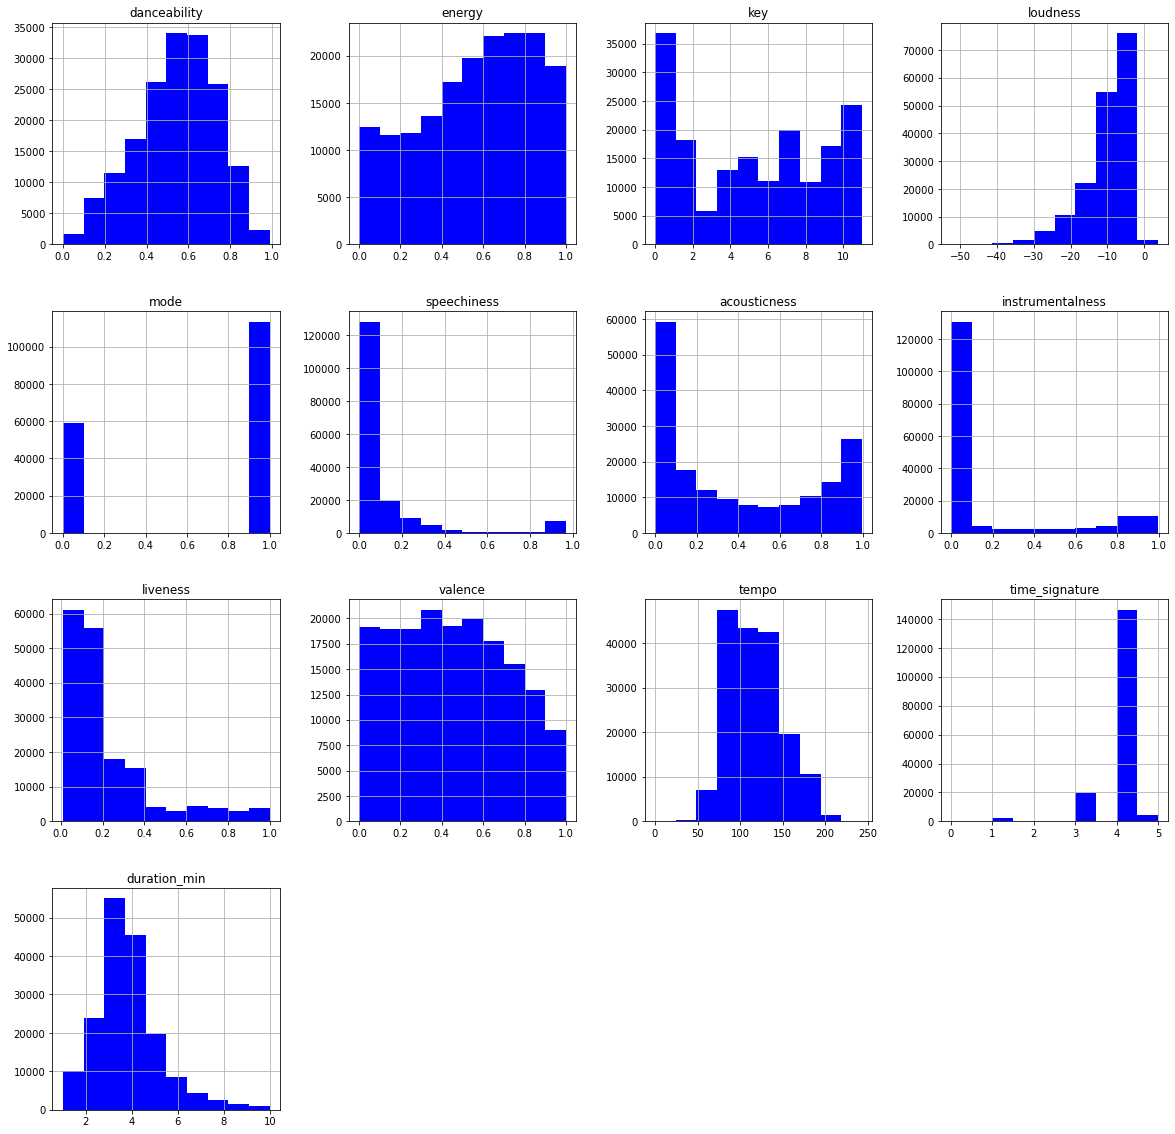

In [6]:
# Plotting the histogramms of all values
tracks.hist(figsize=(20, 20), color="b")
plt.show()
plt.style.use('ggplot')

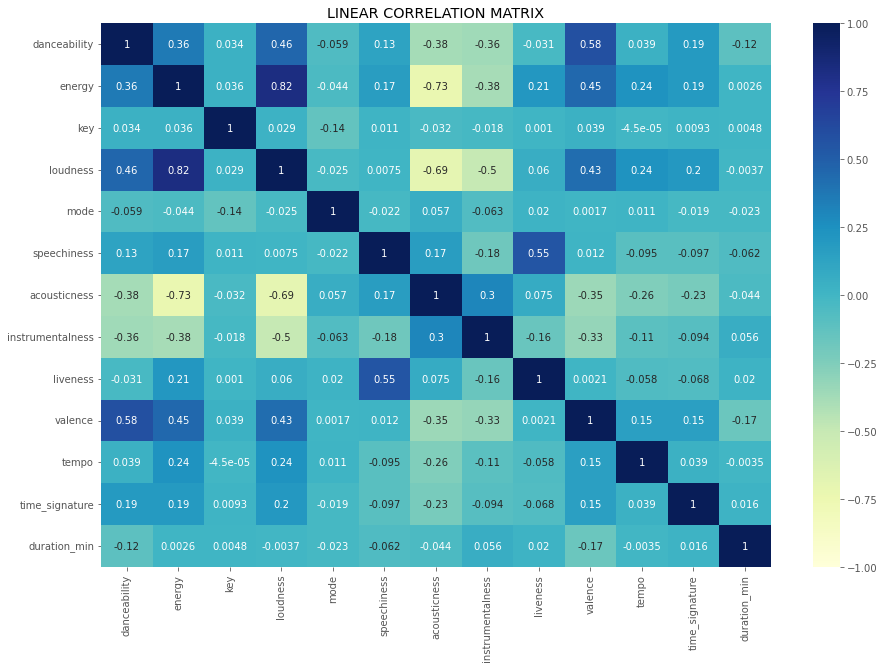

In [7]:
# Plot linear correlation matrix
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(tracks.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.title('LINEAR CORRELATION MATRIX')
plt.show()
plt.style.use('ggplot')

In [8]:
# Calculate the most linear correlated features to Valence
corr = np.abs(tracks.corr())
series = np.abs(corr['valence']).sort_values(ascending=False)
print('The most linear correlated features to VALENCE are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to VALENCE are:
danceability      -->  0.58 (abs)
energy            -->  0.45 (abs)
loudness          -->  0.43 (abs)
acousticness      -->  0.35 (abs)
instrumentalness  -->  0.33 (abs)


### Regression Model

In [9]:
import statsmodels.formula.api as smf

all_columns = list(tracks.columns)
all_columns.remove('valence')
all_columns.remove('song_id')
formula = 'valence' + " ~ " + '+'.join(all_columns)

mod = smf.ols(formula=formula, data=tracks)
regr = mod.fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                 1.206e+04
Date:                Sun, 09 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:18:58   Log-Likelihood:                 35654.
No. Observations:              172320   AIC:                        -7.128e+04
Df Residuals:                  172307   BIC:                        -7.115e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3307      0.006    -52.505      0.000      -0.343      -0.318
danceability         0.7309      0.003    241.586      0.000       0.725       0.737
energy               0.5002      0.004    131.705      0.000       0.493       0.508
key                  0.0014      0.000     10.161      0.000       0.001       0.002
loudness            -0.0079      0.000    -51.208      0.000      -0.008      -0.008
mode                 0.0167      0.001     16.408      0.000       0.015       0.019
speechiness         -0.2472      0.003    -77.669      0.000      -0.253      -0.241
acousticness         0.1225      0.002     55.655      0.000       0.118       0.127
instrumentalness    -0.0851      0.002    -47.298      0.000      -0.089      -0.082
liveness             0.0002      0.003      0.059      0.953      -0.005       0.006
tempo                0.0006   1.59e-05     37.291      0.000       0.001       0.001
time_signature       0.0031      0.001      3.041      0.002       0.001       0.005
duration_min        -0.0198      0.000    -58.119      0.000      -0.021      -0.019
==============================================================================
Omnibus:                      495.170   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              388.190
Skew:                          -0.018   Prob(JB):                     5.08e-85
Kurtosis:                       2.770   Cond. No.                     1.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Conclusion
As we can see from our results the most **correlated features to valence** are: **danceability, energy, loudness, acousticness, instrumentalness.**
Also, we can notice from our model that all the features are statistically important except from the **liveness**. 

## Part 2: Predict Valence
---
In this part we will use Machine Learning techniques to predict valence based on track features. We will use five different methods. As base model we will use the **Linear Regression method** and calculate the *Mean Square Error* and *Mean Absolute Error*. In the remain four models we try to tune the hyperparameters as best as we can to reduce those types of errors. <br>For the hyperparameter tuning we use either the *GridSearchCV* or the *RandomizedSearchCV* technique from scikit-learn. We evaluate the predictions on a holdout 20% testing dataset.  

The models are:
* **Linear Regression Model** 
* **Decision Tree Regressor Model**
* **Random Forest Regressor Model**
* **XGBoost Regressor Model**
* **LightGBM Regressor Model**

In [10]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split

### Data Preparation

In [11]:
df = tracks.drop(['song_id'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['valence'] , axis=1), 
                                                    df['valence'], test_size = 0.2, random_state = 12345)

### Linear Regression Model

In [12]:
# Linear Regressor
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred = linear_reg.predict(X_test)
mse1 = round(mean_squared_error(y_test, y_pred),4)
mae1 = round(mean_absolute_error(y_test, y_pred),4)
print('Mean Squared Error: ', "{:.4f}".format(mse1) , " \nMean Absolute Error:", "{:.4f}".format(mae1))

Mean Squared Error:  0.0387  
Mean Absolute Error: 0.1584


========== Importance of audio features ========== 

1. Variable 0 danceability (0.730904)
2. Variable 1 energy (0.499529)
3. Variable 5 speechiness (0.247741)
4. Variable 6 acousticness (0.122591)
5. Variable 7 instrumentalness (0.085669)
6. Variable 11 duration_min (0.019954)
7. Variable 4 mode (0.016565)
8. Variable 3 loudness (0.007930)
9. Variable 10 time_signature (0.003256)
10. Variable 8 liveness (0.001871)
11. Variable 2 key (0.001327)
12. Variable 9 tempo (0.000593)


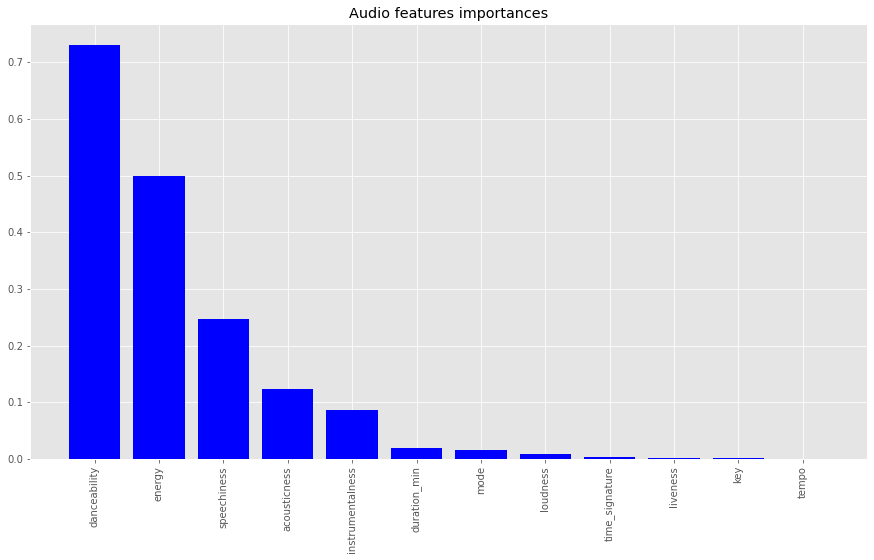

In [13]:
# Importance of audio features
importances = np.abs(linear_reg.coef_)
indices = np.argsort(importances)[::-1]
print('='*10,'Importance of audio features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
# Plot the audio features importances of the Linear Regressor
plt.figure(figsize=(15, 8))
plt.title("Audio features importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="b",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### Decision Tree Regressor Model

**Hyperparameters:**
* *max_depth:* Controls the overall complexity of a decision tree.
* *min_samples_leaf:* Defines the minimum samples (or observations) required in a terminal node or leaf.

In [14]:
# Desision Tree Regressor
decision_tree = DecisionTreeRegressor(max_depth=20, min_samples_leaf = 100)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
mse2 = round(mean_squared_error(y_test, y_pred),4)
mae2 = round(mean_absolute_error(y_test, y_pred),4)
print('Mean Squared Error: ', "{:.4f}".format(mse2) , " \nMean Absolute Error:", "{:.4f}".format(mae2))

Mean Squared Error:  0.0356  
Mean Absolute Error: 0.1475


========== Importance Features ========== 

1. Variable 0 danceability (0.585003)
2. Variable 1 energy (0.193878)
3. Variable 5 speechiness (0.054970)
4. Variable 11 duration_min (0.045201)
5. Variable 9 tempo (0.030355)
6. Variable 6 acousticness (0.026001)
7. Variable 3 loudness (0.024743)
8. Variable 7 instrumentalness (0.020691)
9. Variable 8 liveness (0.016467)
10. Variable 4 mode (0.001766)
11. Variable 2 key (0.000926)
12. Variable 10 time_signature (0.000000)


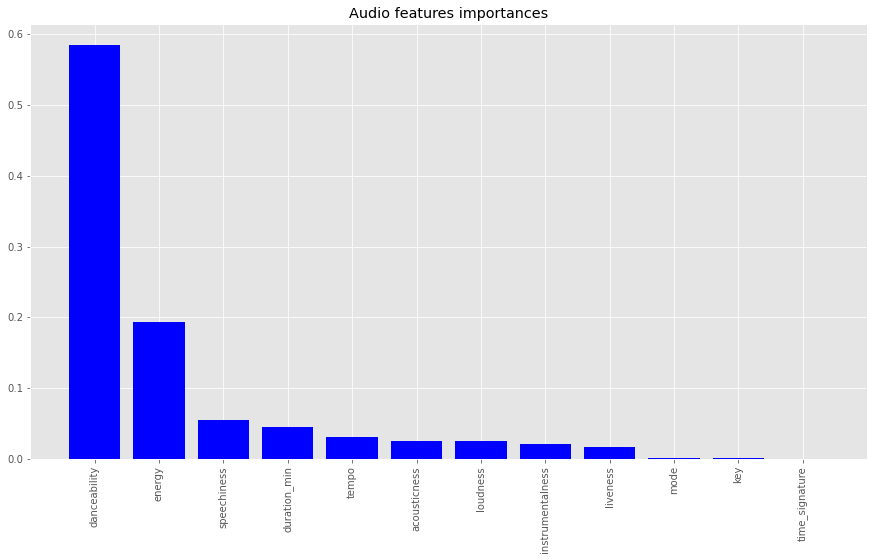

In [15]:
# Importance of audio features
importances = decision_tree.feature_importances_
indices = np.argsort(importances)[::-1]
print('='*10,'Importance Features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
# Plot the audio features importances of the Decision Tree Regressor
plt.figure(figsize=(15, 8))
plt.title("Audio features importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="b",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### Random Forest Regressor Model

**Hyperparameters:**
* *max_depth:* The longest path between the root node and the leaf node
* *n_estimators:* Number of trees in the foreset.
* *min_samples_leaf:* Specifies the minimum number of samples that should be present in the leaf node after splitting a node.

In [16]:
# Random Forest Regressor
random_forest = RandomForestRegressor(max_depth = 20, n_estimators = 700, min_samples_leaf = 10)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
mse3 = round(mean_squared_error(y_test, y_pred),4)
mae3 = round(mean_absolute_error(y_test, y_pred),4)
print('Mean Squared Error: ', "{:.4f}".format(mse3) , " \nMean Absolute Error:", "{:.4f}".format(mae3))

Mean Squared Error:  0.0308  
Mean Absolute Error: 0.1370


========== Importance Features ========== 

1. Variable 0 danceability (0.460498)
2. Variable 1 energy (0.174115)
3. Variable 5 speechiness (0.069001)
4. Variable 11 duration_min (0.059110)
5. Variable 9 tempo (0.052704)
6. Variable 3 loudness (0.047810)
7. Variable 6 acousticness (0.046265)
8. Variable 8 liveness (0.037109)
9. Variable 7 instrumentalness (0.036812)
10. Variable 2 key (0.011887)
11. Variable 4 mode (0.004104)
12. Variable 10 time_signature (0.000587)


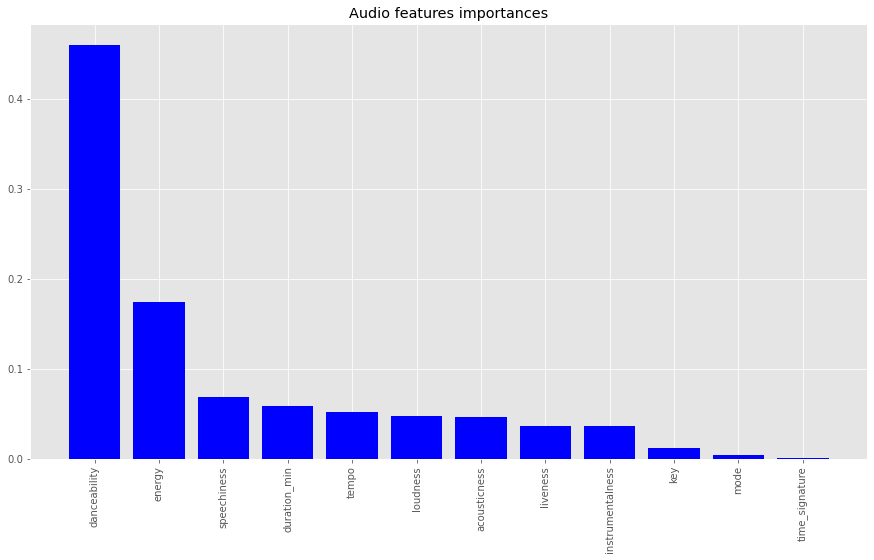

In [17]:
# Importance of audio features
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
print('='*10,'Importance Features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
# Plot the audio features importances of the Random Forest Regressor
plt.figure(figsize=(15, 8))
plt.title("Audio features importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="b",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### XGBoost Regressor Model

**Hyperparameters:**
* *objective:* Defines the loss function to be minimized.
* *colsample_bytree:* Corresponds to the fraction of features (the columns) to use
* *learning_rate:* The step size parameter of the gradient descent.
* *max_depth:*  The maximum number of nodes allowed from the root to the farthest leaf of a tree.
* *n_estimators:* Controls the number of decision trees.

In [18]:
# XGBoost Regressor
xgb_reg = XGBRegressor(objective='reg:squarederror', colsample_bytree = 0.7, 
                       learning_rate = 0.01, max_depth = 10, n_estimators = 1000)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)
mse4 = round(mean_squared_error(y_test, y_pred),4)
mae4 = round(mean_absolute_error(y_test, y_pred),4)
print('Mean Squared Error: ', "{:.4f}".format(mse4) , " \nMean Absolute Error:", "{:.4f}".format(mae4))

Mean Squared Error:  0.0292  
Mean Absolute Error: 0.1333


========== Importance Features ========== 

1. Variable 0 danceability (0.324996)
2. Variable 1 energy (0.136751)
3. Variable 3 loudness (0.072152)
4. Variable 5 speechiness (0.064095)
5. Variable 11 duration_min (0.061394)
6. Variable 6 acousticness (0.058413)
7. Variable 9 tempo (0.056737)
8. Variable 7 instrumentalness (0.056607)
9. Variable 10 time_signature (0.054373)
10. Variable 8 liveness (0.050794)
11. Variable 4 mode (0.040941)
12. Variable 2 key (0.022748)


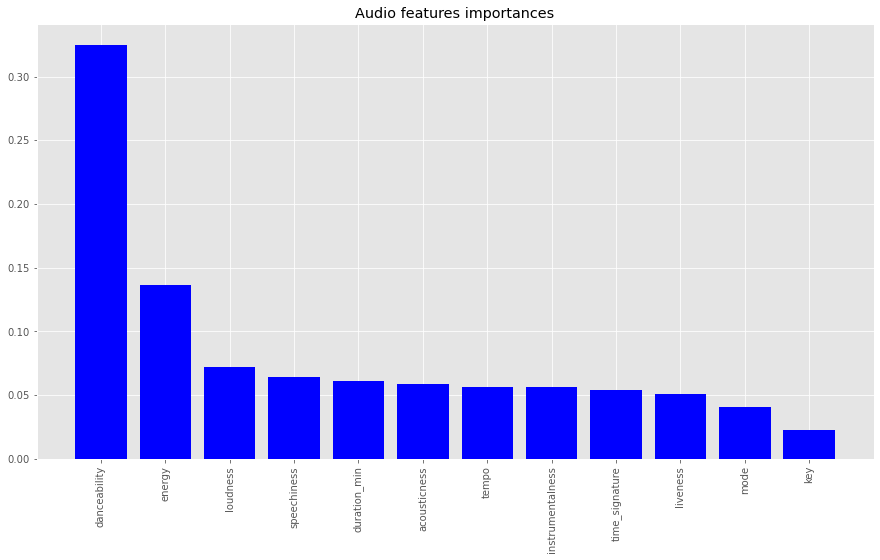

In [19]:
# Importance of audio features
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]
print('='*10,'Importance Features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
# Plot the audio features importances of the XGBoost Regressor
plt.figure(figsize=(15, 8))
plt.title("Audio features importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="b",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### LightGBM Regressor Model

**Hyperparameters:**
* *objective:* Defines the objective function to use for the task.
* *learning_rate:* The step size parameter of the gradient descent.
* *max_depth:* Specify the maximum depth allowed for trees in the ensemble.
* *num_leaves:* Controls the number of decision leaves in a single tree.
* *n_estimators:* Controls the number of decision trees.

In [20]:
# LightGBM Regressor
lgbm_reg = LGBMRegressor(objective = 'cross_entropy',learning_rate=0.05, 
                         max_depth = 45, num_leaves=100, n_estimators=2000)
lgbm_reg.fit(X_train, y_train)
y_pred = lgbm_reg.predict(X_test)
mse5 = round(mean_squared_error(y_test, y_pred),4)
mae5 = round(mean_absolute_error(y_test, y_pred),4)
print('Mean Squared Error: ', "{:.4f}".format(mse5) , " \nMean Absolute Error:", "{:.4f}".format(mae5))

Mean Squared Error:  0.0292  
Mean Absolute Error: 0.1317


========== Importance Features ========== 

1. Variable 5 speechiness (22104.000000)
2. Variable 0 danceability (22065.000000)
3. Variable 11 duration_min (21485.000000)
4. Variable 1 energy (21190.000000)
5. Variable 6 acousticness (20962.000000)
6. Variable 9 tempo (20723.000000)
7. Variable 3 loudness (20085.000000)
8. Variable 8 liveness (19698.000000)
9. Variable 7 instrumentalness (17304.000000)
10. Variable 2 key (9193.000000)
11. Variable 4 mode (2210.000000)
12. Variable 10 time_signature (981.000000)


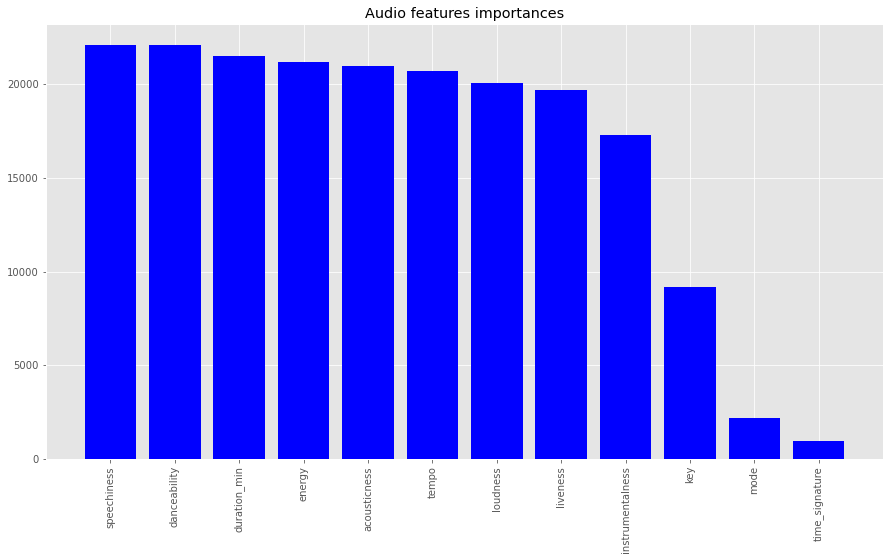

In [21]:
# Importance of audio features
importances = lgbm_reg.feature_importances_
indices = np.argsort(importances)[::-1]
print('='*10,'Importance Features','='*10,'\n')
for f in range(X_train.shape[1]):
    print("%d. Variable %d %s (%f)" % (f + 1, indices[f], list(X_train.columns)[indices[f]], importances[indices[f]]))
    
# Plot the audio features importances of the LightGBM Regressor
plt.figure(figsize=(15, 8))
plt.title("Audio features importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        tick_label=[list(X_train.columns)[x] for x in indices],
        color="b",  align="center")
plt.xlim([-1, X_train.shape[1]])
g = plt.xticks(rotation=90)
plt.style.use('ggplot')

### Results

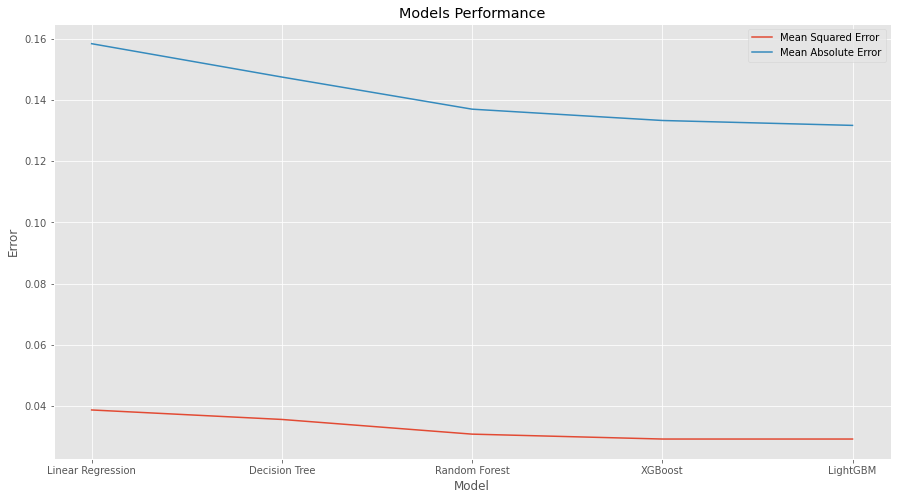

In [22]:
# Dataframe Results and Plotting
data = {'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
        'Mean Squared Error': [mse1,mse2,mse3,mse4,mse5],
       'Mean Absolute Error': [mae1,mae2,mae3,mae4,mae5]} 
results = pd.DataFrame(data)
ax = results.plot(figsize=(15, 8),title = "Models Performance")
ax.set(xlabel="Model",ylabel='Error')
ax.set_xticks(results.index)
ax.set_xticklabels(results.Model)
plt.style.use('ggplot')
plt.show()

After trying different models, we achieve to decrease the *Mean Squared* and *Mean Absolute Error* from our base model in all occasions. **LightGBM Regressor** gives as the best results with a ***16.86 %*** decrease in *Mean Absolute Error* ***(0.1317)***  from the base model ***(0.1584)*** after the hyperparameter tuning.

***Danceability*** is the most important audio feaute in all occasions. Also, ***energy*** and ***speechiness*** are important ones. It is something we expect because they have high correlation with the predictor variable. On the other hand, the categorical variables ***key, mode*** and ***time signature*** are the least importants ones in almost all the models.

|Model | Mean Squared Error | Mean Absolute Error |
| :- | -: | :-: |
|Linear Regression | 0.0387 | 0.1584 |
|Decision Tree  | 0.0356 | 0.1475 |
|Random Forest  | 0.0308 | 0.1370 |
|XGBoost  | 0.0292 | 0.1333 |
|LightGBM  | 0.0292 | 0.1317 |

### Bonus* (Try the models in external dataset)

After have tuned our models, we will apply them in real and different dataset of songs. We will use the same methods as above to download the audio features of each song and based on them we will try to predict valence. At the end we will compare the results with the real values and calculate our model performance.  

### Songs Dataset

In [23]:
# Test songs dataset 
test_songs = pd.read_csv('data/spotify_ids.txt', header = None, names = ['song_ids'])

# Spotify API download song features(100 each time)
features_test = {}
test_track_ids = list(test_songs['song_ids'])
start = 0
num_tracks = 100
while start < len(test_track_ids):
    tracks_batch = test_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features_test.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks
    
print('Total Test Songs ids:', len(test_songs['song_ids'].unique()))
print('Test Songs ids download from Spotify:', len(features_test))

# Dataframe creation with audio features
tracks_test = pd.DataFrame.from_dict(features_test, orient='index')
tracks_test = tracks_test.reset_index().rename(columns={'index':'song_id'})
tracks_test

Total Test Songs ids: 1162
Test Songs ids download from Spotify: 1162


,song_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,7lPN2DXiMsVn7XUKtOW1CS,0.585,0.436,10,-8.761,1,0.0601,0.72100,0.000013,0.1050,0.132,143.874,audio_features,7lPN2DXiMsVn7XUKtOW1CS,spotify:track:7lPN2DXiMsVn7XUKtOW1CS,https://api.spotify.com/v1/tracks/7lPN2DXiMsVn...,https://api.spotify.com/v1/audio-analysis/7lPN...,242014,4
1,5QO79kh1waicV47BqGRL3g,0.680,0.826,0,-5.487,1,0.0309,0.02120,0.000012,0.5430,0.644,118.051,audio_features,5QO79kh1waicV47BqGRL3g,spotify:track:5QO79kh1waicV47BqGRL3g,https://api.spotify.com/v1/tracks/5QO79kh1waic...,https://api.spotify.com/v1/audio-analysis/5QO7...,215627,4
2,0VjIjW4GlUZAMYd2vXMi3b,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
3,4MzXwWMhyBbmu6hOcLVD49,0.731,0.573,4,-10.059,0,0.0544,0.40100,0.000052,0.1130,0.145,109.928,audio_features,4MzXwWMhyBbmu6hOcLVD49,spotify:track:4MzXwWMhyBbmu6hOcLVD49,https://api.spotify.com/v1/tracks/4MzXwWMhyBbm...,https://api.spotify.com/v1/audio-analysis/4MzX...,205090,4
4,5Kskr9LcNYa0tpt5f0ZEJx,0.907,0.393,4,-7.636,0,0.0539,0.45100,0.000001,0.1350,0.202,104.949,audio_features,5Kskr9LcNYa0tpt5f0ZEJx,spotify:track:5Kskr9LcNYa0tpt5f0ZEJx,https://api.spotify.com/v1/tracks/5Kskr9LcNYa0...,https://api.spotify.com/v1/audio-analysis/5Ksk...,205458,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,4lUmnwRybYH7mMzf16xB0y,0.596,0.650,9,-5.167,1,0.3370,0.13800,0.000000,0.1400,0.188,133.997,audio_features,4lUmnwRybYH7mMzf16xB0y,spotify:track:4lUmnwRybYH7mMzf16xB0y,https://api.spotify.com/v1/tracks/4lUmnwRybYH7...,https://api.spotify.com/v1/audio-analysis/4lUm...,257428,4
1158,1fzf9Aad4y1RWrmwosAK5y,0.588,0.850,4,-6.431,1,0.0318,0.16800,0.002020,0.0465,0.768,93.003,audio_features,1fzf9Aad4y1RWrmwosAK5y,spotify:track:1fzf9Aad4y1RWrmwosAK5y,https://api.spotify.com/v1/tracks/1fzf9Aad4y1R...,https://api.spotify.com/v1/audio-analysis/1fzf...,187310,4
1159,3E3pb3qH11iny6TFDJvsg5,0.754,0.660,0,-6.811,1,0.2670,0.17900,0.000000,0.1940,0.316,83.000,audio_features,3E3pb3qH11iny6TFDJvsg5,spotify:track:3E3pb3qH11iny6TFDJvsg5,https://api.spotify.com/v1/tracks/3E3pb3qH11in...,https://api.spotify.com/v1/audio-analysis/3E3p...,209299,4
1160,3yTkoTuiKRGL2VAlQd7xsC,0.584,0.836,0,-4.925,1,0.0790,0.05580,0.000000,0.0663,0.484,104.973,audio_features,3yTkoTuiKRGL2VAlQd7xsC,spotify:track:3yTkoTuiKRGL2VAlQd7xsC,https://api.spotify.com/v1/tracks/3yTkoTuiKRGL...,https://api.spotify.com/v1/audio-analysis/3yTk...,202204,4


In [24]:
# Dataframe manipulation to match the model
tracks_test['duration_min'] = tracks_test.duration_ms/60000
tracks_test_features = tracks_test.drop(['type','id','uri','track_href','analysis_url',
                                         'song_id','duration_ms','valence'],axis=1)  

### Predictions and Evaluation

In [25]:
# Linear regressor
y_pred = linear_reg.predict(tracks_test_features)
mse11 = round(mean_squared_error(tracks_test['valence'], y_pred),4)
mae11 = round(mean_absolute_error(tracks_test['valence'], y_pred),4)
print('Linear regressor Model')
print('Mean Squared Error: ', "{:.4f}".format(mse11) , " \nMean Absolute Error:", "{:.4f}\n".format(mae11))

# Desision Tree Regressor
y_pred = decision_tree.predict(tracks_test_features)
mse22 = round(mean_squared_error(tracks_test['valence'], y_pred),4)
mae22 = round(mean_absolute_error(tracks_test['valence'], y_pred),4)
print('Desision Tree Regressor Model')
print('Mean Squared Error: ', "{:.4f}".format(mse22) , " \nMean Absolute Error:", "{:.4f}\n".format(mae22))

# Random Forest Regressor
y_pred = random_forest.predict(tracks_test_features)
mse33 = round(mean_squared_error(tracks_test['valence'], y_pred),4)
mae33 = round(mean_absolute_error(tracks_test['valence'], y_pred),4)
print('Random Forest Regressor Model')
print('Mean Squared Error: ', "{:.4f}".format(mse33) , " \nMean Absolute Error:", "{:.4f}\n".format(mae33))

# XGBoost Regressor
y_pred = xgb_reg.predict(tracks_test_features)
mse44 = round(mean_squared_error(tracks_test['valence'], y_pred),4)
mae44 = round(mean_absolute_error(tracks_test['valence'], y_pred),4)
print('XGBoost Regressor MOdel')
print('Mean Squared Error: ', "{:.4f}".format(mse44) , " \nMean Absolute Error:", "{:.4f}\n".format(mae44))

# LightGBM Regressor
y_pred = lgbm_reg.predict(tracks_test_features)
mse55 = round(mean_squared_error(tracks_test['valence'], y_pred),4)
mae55 = round(mean_absolute_error(tracks_test['valence'], y_pred),4)
print('LightGBM Regressor Model')
print('Mean Squared Error: ', "{:.4f}".format(mse55) , " \nMean Absolute Error:", "{:.4f}".format(mae55))

Linear regressor Model
Mean Squared Error:  0.0396  
Mean Absolute Error: 0.1603

Desision Tree Regressor Model
Mean Squared Error:  0.0399  
Mean Absolute Error: 0.1606

Random Forest Regressor Model
Mean Squared Error:  0.0347  
Mean Absolute Error: 0.1505

XGBoost Regressor MOdel
Mean Squared Error:  0.0329  
Mean Absolute Error: 0.1467

LightGBM Regressor Model
Mean Squared Error:  0.0344  
Mean Absolute Error: 0.1484


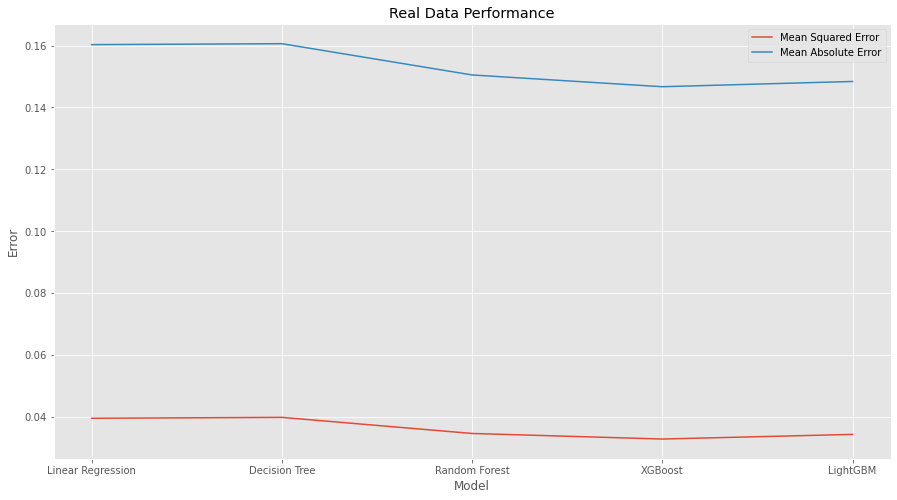

In [26]:
data = {'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
        'Mean Squared Error': [mse11,mse22,mse33,mse44,mse55],
       'Mean Absolute Error': [mae11,mae22,mae33,mae44,mae55]} 
results = pd.DataFrame(data)
ax = results.plot(figsize=(15, 8),title = "Real Data Performance")
ax.set(xlabel="Model",ylabel='Error')
ax.set_xticks(results.index)
ax.set_xticklabels(results.Model)
plt.style.use('ggplot')
plt.show()

From the results we can observe that the ***XGBoost Regressor*** gives the best predictions on the dataset with ***Mean Absolute Error (0.1467)***. The ***LightGBM Regressor*** which find that is our best model above gives a slightly higher ***Mean Absolute Error (0.1484)***. 

|Model | Mean Squared Error | Mean Absolute Error |
| :- | -: | :-: |
|Linear Regression | 0.0396 | 0.1603 |
|Decision Tree  | 0.0399 | 0.1606 |
|Random Forest  | 0.0347 | 0.1505 |
|XGBoost  | 0.0329 | 0.1467 |
|LightGBM  | 0.0344 | 0.1484 |